# Imports

In [1]:
import comet_ml
from comet_ml import Experiment
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch import nn
import matplotlib.pyplot as plt

In [2]:
import transformers
from transformers import *
import numpy as np
from datasets import load_dataset
import evaluate
from tqdm import tqdm

comet_ml is installed but `COMET_API_KEY` is not set.
/Users/milosz/opt/miniconda3/envs/pt/lib/python3.9/site-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(


In [3]:
from datasets import load_dataset
import datasets

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification, DataCollatorWithPadding

In [4]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


In [5]:
RANDOM_SEED = 42
VALIDATION_PERCENTAGE = 10
# PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased'
# PRE_TRAINED_MODEL_NAME = 'distilbert-base-uncased-finetuned-sst-2-english'
# PRE_TRAINED_MODEL_NAME = "bert-base-uncased"
PRE_TRAINED_MODEL_NAME = "nlptown/bert-base-multilingual-uncased-sentiment"

# Load and prepare data

In [6]:
full_train_dataset = load_dataset("csv", data_files="p6/train_data.csv")

train_dataset, valid_dataset = datasets.load_dataset("csv", data_files="p6/train_data.csv", split=[
    datasets.ReadInstruction('train', to=100-VALIDATION_PERCENTAGE, unit='%'),
    datasets.ReadInstruction('train', from_=-VALIDATION_PERCENTAGE, unit='%'),
])

test_dataset = load_dataset("csv", data_files="p6/test_data.csv", column_names=['review'])

Using custom data configuration default-287925a4e04bbfc0


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /Users/milosz/.cache/huggingface/datasets/csv/default-287925a4e04bbfc0/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


/Users/milosz/opt/miniconda3/envs/pt/lib/python3.9/site-packages/datasets/download/streaming_download_manager.py:727: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-287925a4e04bbfc0
Found cached dataset csv (/Users/milosz/.cache/huggingface/datasets/csv/default-287925a4e04bbfc0/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/2 [00:00<?, ?it/s]

Using custom data configuration default-a03d258a1c94f7de


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /Users/milosz/.cache/huggingface/datasets/csv/default-a03d258a1c94f7de/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


/Users/milosz/opt/miniconda3/envs/pt/lib/python3.9/site-packages/datasets/download/streaming_download_manager.py:727: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# rename label column
full_train_dataset = full_train_dataset.rename_column('rating', 'label')
train_dataset = train_dataset.rename_column('rating', 'label')
valid_dataset = valid_dataset.rename_column('rating', 'label')

In [8]:
print(full_train_dataset)

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 16392
    })
})


In [9]:
print(train_dataset)

Dataset({
    features: ['review', 'label'],
    num_rows: 14753
})


In [10]:
print(valid_dataset)

Dataset({
    features: ['review', 'label'],
    num_rows: 1639
})


In [11]:
print(test_dataset)

DatasetDict({
    train: Dataset({
        features: ['review'],
        num_rows: 4099
    })
})


(array([1137.,    0., 1434.,    0.,    0., 1747.,    0., 4831.,    0.,
        7243.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

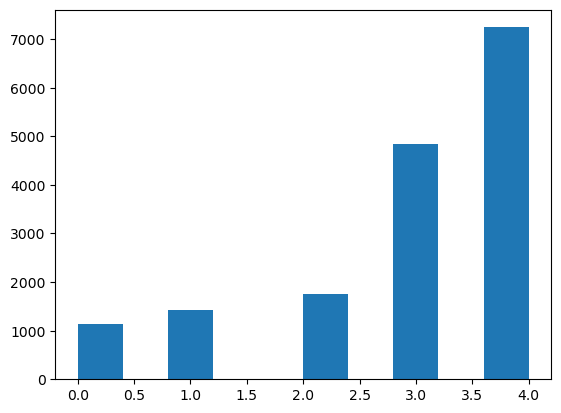

In [12]:
plt.hist(full_train_dataset['train']['label'])

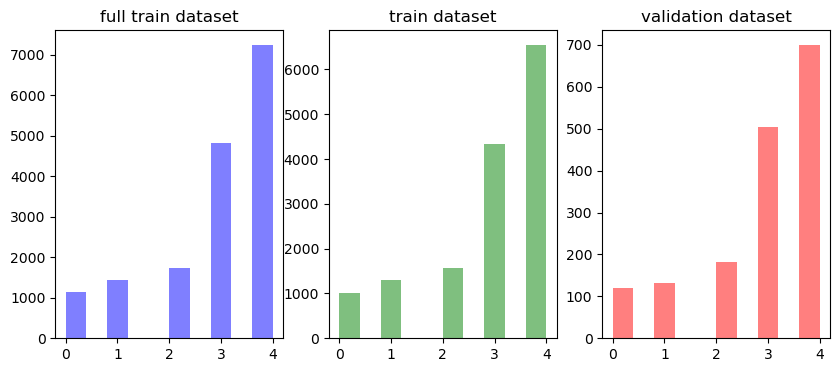

In [13]:
# Create a 3x1 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(10,4))

# Plot the first histogram in the first subplot
axs[0].hist(full_train_dataset['train']['label'], color='blue', alpha=0.5)
axs[0].set_title('full train dataset')

# Plot the second histogram in the second subplot
axs[1].hist(train_dataset['label'], color='green', alpha=0.5)
axs[1].set_title('train dataset')

# Plot the third histogram in the third subplot
axs[2].hist(valid_dataset['label'], color='red', alpha=0.5)
axs[2].set_title('validation dataset')

plt.show()

## Compute class weights

In [14]:
from sklearn.utils.class_weight import compute_class_weight


CLASS_WEIGHT= compute_class_weight(class_weight='balanced', classes=np.unique(train_dataset['label']).tolist(), y=train_dataset['label'])
classes_weights = torch.tensor(np.array(CLASS_WEIGHT).astype('float32')).to(device)

In [15]:
for class_idx, class_weight in zip(np.unique(train_dataset['label']), CLASS_WEIGHT):
    print(class_idx, class_weight)

0 2.9041338582677168
1 2.266205837173579
2 1.8865728900255754
3 0.6817467652495379
4 0.45095521931835547


## Tokenization

In [16]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

def tokenize_function(data):
    return tokenizer(data["review"], padding="max_length", truncation=True)


tokenized_train_df = train_dataset.map(tokenize_function, batched=True)
tokenized_valid_df = valid_dataset.map(tokenize_function, batched=True)

tokenized_train_df = tokenized_train_df.remove_columns(['review'])
tokenized_valid_df = tokenized_valid_df.remove_columns(['review'])

tokenized_train_df.set_format("torch")
tokenized_valid_df.set_format("torch")

# train_df = tokenized_train_df.shuffle(seed=RANDOM_SEED).select(range(200))
# valid_df = tokenized_valid_df.shuffle(seed=RANDOM_SEED).select(range(100))
train_df = tokenized_train_df
valid_df = tokenized_valid_df

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

loading configuration file config.json from cache at /Users/milosz/.cache/huggingface/hub/models--nlptown--bert-base-multilingual-uncased-sentiment/snapshots/e06857fdb0325a7798a8fc361b417dfeec3a3b98/config.json
Model config BertConfig {
  "_name_or_path": "nlptown/bert-base-multilingual-uncased-sentiment",
  "_num_labels": 5,
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "finetuning_task": "sentiment-analysis",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "1 star",
    "1": "2 stars",
    "2": "3 stars",
    "3": "4 stars",
    "4": "5 stars"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "1 star": 0,
    "2 stars": 1,
    "3 stars": 2,
    "4 stars": 3,
    "5 stars": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads"

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [17]:
print(train_df)

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 14753
})


In [18]:
print(valid_df)

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1639
})


# Define model

In [19]:
# model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_MODEL_NAME, num_labels=5
)

loading configuration file config.json from cache at /Users/milosz/.cache/huggingface/hub/models--nlptown--bert-base-multilingual-uncased-sentiment/snapshots/e06857fdb0325a7798a8fc361b417dfeec3a3b98/config.json
Model config BertConfig {
  "_name_or_path": "nlptown/bert-base-multilingual-uncased-sentiment",
  "_num_labels": 5,
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "finetuning_task": "sentiment-analysis",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "1 star",
    "1": "2 stars",
    "2": "3 stars",
    "3": "4 stars",
    "4": "5 stars"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "1 star": 0,
    "2 stars": 1,
    "3 stars": 2,
    "4 stars": 3,
    "5 stars": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads"

In [20]:
training_arguments = TrainingArguments(
    seed=RANDOM_SEED,
    optim="adamw_torch",
    learning_rate=5e-5,
    num_train_epochs=100,
    output_dir="./results",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    evaluation_strategy="steps",
    eval_steps=25,
    save_strategy="steps",
    save_total_limit=10,
    save_steps=25,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [21]:
# read comet API key from a file
with open('api_key.txt', 'r') as file:
    API_KEY = file.readline().strip()

In [22]:
experiment = Experiment(
    api_key=API_KEY,
    project_name="hotel_stars_v3_with_weights",
    workspace="milosz-l",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


COMET INFO: Experiment is live on comet.com https://www.comet.com/milosz-l/hotel-stars-v3-with-weights/254e349ea59e4bcebb3778d069fb5f4f



In [23]:
def compute_metrics(pred):
    
    #get global experiments
    # experiment = comet_ml.get_global_experiment()
    
    #get y_true and y_preds for eval_dataset
    # print(f'pred = {pred}')
    labels = pred.label_ids
    # print(f'labels = {labels}')
    preds = pred.predictions.argmax(-1)
    # print(f'preds = {preds}')
    
    #compute precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='macro')
    
    #compute accuracy score
    acc = accuracy_score(labels, preds)
    
    #log confusion matrix
    if experiment:
        epoch = int(experiment.curr_epoch) if experiment.curr_epoch is not None else 0
        experiment.set_epoch(epoch)
        experiment.log_confusion_matrix(
            y_true=labels,
            y_predicted=preds,
            labels=[1, 2, 3, 4, 5]
        )

    return {"accuracy": acc, 
            "f1": f1, 
            "precision": precision,
            "recall": recall
            }

In [24]:
# override Trainer for adding class weighting


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=classes_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [25]:
%env COMET_MODE=ONLINE
%env COMET_LOG_ASSETS=TRUE
trainer = CustomTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_df,
    eval_dataset=valid_df,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

env: COMET_MODE=ONLINE
env: COMET_LOG_ASSETS=TRUE
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [26]:
trainer.train()

***** Running training *****
  Num examples = 14753
  Num Epochs = 100
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 184500
  Number of trainable parameters = 167360261
COMET ERROR: Failed to extract scalar from SummaryWriter.add_hparams()


  0%|          | 0/184500 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-25
Configuration saved in ./results/checkpoint-25/config.json


{'eval_loss': 1.2076008319854736, 'eval_accuracy': 0.5607077486272117, 'eval_f1': 0.43714014915115207, 'eval_precision': 0.45326865323888355, 'eval_recall': 0.46356838503305753, 'eval_runtime': 323.1968, 'eval_samples_per_second': 5.071, 'eval_steps_per_second': 0.634, 'epoch': 0.01}


Model weights saved in ./results/checkpoint-25/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-50
Configuration saved in ./results/checkpoint-50/config.json


{'eval_loss': 1.142885446548462, 'eval_accuracy': 0.5753508236729713, 'eval_f1': 0.4849776253473033, 'eval_precision': 0.5962432473609083, 'eval_recall': 0.4942972833254215, 'eval_runtime': 322.7082, 'eval_samples_per_second': 5.079, 'eval_steps_per_second': 0.635, 'epoch': 0.03}


Model weights saved in ./results/checkpoint-50/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-25] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

/Users/milosz/opt/miniconda3/envs/pt/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./results/checkpoint-75
Configuration saved in ./results/checkpoint-75/config.json


{'eval_loss': 1.3661912679672241, 'eval_accuracy': 0.5405735204392923, 'eval_f1': 0.35343348397485846, 'eval_precision': 0.3479287826692584, 'eval_recall': 0.3752617754547162, 'eval_runtime': 321.2273, 'eval_samples_per_second': 5.102, 'eval_steps_per_second': 0.638, 'epoch': 0.04}


Model weights saved in ./results/checkpoint-75/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1550] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-100
Configuration saved in ./results/checkpoint-100/config.json


{'eval_loss': 1.0947518348693848, 'eval_accuracy': 0.5259304453935326, 'eval_f1': 0.4323829145608933, 'eval_precision': 0.45457470220072205, 'eval_recall': 0.5047740464907922, 'eval_runtime': 327.456, 'eval_samples_per_second': 5.005, 'eval_steps_per_second': 0.626, 'epoch': 0.05}


Model weights saved in ./results/checkpoint-100/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1575] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-125
Configuration saved in ./results/checkpoint-125/config.json


{'eval_loss': 1.151579737663269, 'eval_accuracy': 0.5430140329469189, 'eval_f1': 0.5119944534869221, 'eval_precision': 0.5786226302855562, 'eval_recall': 0.5072202899274567, 'eval_runtime': 321.0836, 'eval_samples_per_second': 5.105, 'eval_steps_per_second': 0.638, 'epoch': 0.07}


Model weights saved in ./results/checkpoint-125/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1600] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-150
Configuration saved in ./results/checkpoint-150/config.json


{'eval_loss': 1.2985361814498901, 'eval_accuracy': 0.5661989017693716, 'eval_f1': 0.4256682238702158, 'eval_precision': 0.5805333586784424, 'eval_recall': 0.42920442211473964, 'eval_runtime': 321.7434, 'eval_samples_per_second': 5.094, 'eval_steps_per_second': 0.637, 'epoch': 0.08}


Model weights saved in ./results/checkpoint-150/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1625] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-175
Configuration saved in ./results/checkpoint-175/config.json


{'eval_loss': 1.0739641189575195, 'eval_accuracy': 0.5625381330079317, 'eval_f1': 0.5156951729833315, 'eval_precision': 0.5562626968717053, 'eval_recall': 0.5343183902501084, 'eval_runtime': 320.6625, 'eval_samples_per_second': 5.111, 'eval_steps_per_second': 0.639, 'epoch': 0.09}


Model weights saved in ./results/checkpoint-175/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1650] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json


{'eval_loss': 1.0462199449539185, 'eval_accuracy': 0.6089078706528371, 'eval_f1': 0.5649353719457472, 'eval_precision': 0.5825271440761, 'eval_recall': 0.5525087676533043, 'eval_runtime': 320.105, 'eval_samples_per_second': 5.12, 'eval_steps_per_second': 0.64, 'epoch': 0.11}


Model weights saved in ./results/checkpoint-200/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1675] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-225
Configuration saved in ./results/checkpoint-225/config.json


{'eval_loss': 1.0735210180282593, 'eval_accuracy': 0.5332519829164124, 'eval_f1': 0.5149232533017509, 'eval_precision': 0.5258149585060536, 'eval_recall': 0.5512258061619895, 'eval_runtime': 320.9894, 'eval_samples_per_second': 5.106, 'eval_steps_per_second': 0.639, 'epoch': 0.12}


Model weights saved in ./results/checkpoint-225/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1700] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-250
Configuration saved in ./results/checkpoint-250/config.json


{'eval_loss': 1.2487666606903076, 'eval_accuracy': 0.49115314215985356, 'eval_f1': 0.4199813425476161, 'eval_precision': 0.5753119226897553, 'eval_recall': 0.4120198646060168, 'eval_runtime': 321.9328, 'eval_samples_per_second': 5.091, 'eval_steps_per_second': 0.637, 'epoch': 0.14}


Model weights saved in ./results/checkpoint-250/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1725] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-275
Configuration saved in ./results/checkpoint-275/config.json


{'eval_loss': 1.1435210704803467, 'eval_accuracy': 0.47712019524100063, 'eval_f1': 0.46639879002209755, 'eval_precision': 0.5594662360664028, 'eval_recall': 0.4962306445197949, 'eval_runtime': 321.889, 'eval_samples_per_second': 5.092, 'eval_steps_per_second': 0.637, 'epoch': 0.15}


Model weights saved in ./results/checkpoint-275/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1750] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-300
Configuration saved in ./results/checkpoint-300/config.json


{'eval_loss': 1.0946141481399536, 'eval_accuracy': 0.6034167175106773, 'eval_f1': 0.5517376043001023, 'eval_precision': 0.5882805541645012, 'eval_recall': 0.5444452715196361, 'eval_runtime': 326.2845, 'eval_samples_per_second': 5.023, 'eval_steps_per_second': 0.628, 'epoch': 0.16}


Model weights saved in ./results/checkpoint-300/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-50] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-325
Configuration saved in ./results/checkpoint-325/config.json


{'eval_loss': 1.130142092704773, 'eval_accuracy': 0.5729103111653447, 'eval_f1': 0.4751172191097101, 'eval_precision': 0.5754041395549532, 'eval_recall': 0.4798105933081711, 'eval_runtime': 327.9825, 'eval_samples_per_second': 4.997, 'eval_steps_per_second': 0.625, 'epoch': 0.18}


Model weights saved in ./results/checkpoint-325/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-75] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-350
Configuration saved in ./results/checkpoint-350/config.json


{'eval_loss': 0.9956300258636475, 'eval_accuracy': 0.6064673581452105, 'eval_f1': 0.5618681690673372, 'eval_precision': 0.5696545765712218, 'eval_recall': 0.561689309385973, 'eval_runtime': 321.1516, 'eval_samples_per_second': 5.104, 'eval_steps_per_second': 0.638, 'epoch': 0.19}


Model weights saved in ./results/checkpoint-350/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-100] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-375
Configuration saved in ./results/checkpoint-375/config.json


{'eval_loss': 1.0505166053771973, 'eval_accuracy': 0.5808419768151312, 'eval_f1': 0.517697706041633, 'eval_precision': 0.5371438108009674, 'eval_recall': 0.5486210349723517, 'eval_runtime': 326.4877, 'eval_samples_per_second': 5.02, 'eval_steps_per_second': 0.628, 'epoch': 0.2}


Model weights saved in ./results/checkpoint-375/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-125] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-400
Configuration saved in ./results/checkpoint-400/config.json


{'eval_loss': 1.0917481184005737, 'eval_accuracy': 0.5308114704087858, 'eval_f1': 0.5113496673672708, 'eval_precision': 0.5279180975847805, 'eval_recall': 0.5252430656927848, 'eval_runtime': 328.3772, 'eval_samples_per_second': 4.991, 'eval_steps_per_second': 0.624, 'epoch': 0.22}


Model weights saved in ./results/checkpoint-400/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-150] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-425
Configuration saved in ./results/checkpoint-425/config.json


{'eval_loss': 1.2123360633850098, 'eval_accuracy': 0.6186699206833435, 'eval_f1': 0.5545515749784278, 'eval_precision': 0.5981873955544875, 'eval_recall': 0.5371230926323916, 'eval_runtime': 321.5775, 'eval_samples_per_second': 5.097, 'eval_steps_per_second': 0.637, 'epoch': 0.23}


Model weights saved in ./results/checkpoint-425/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-175] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-450
Configuration saved in ./results/checkpoint-450/config.json


{'eval_loss': 1.0636109113693237, 'eval_accuracy': 0.5491153142159854, 'eval_f1': 0.5056025174601172, 'eval_precision': 0.4951012421200659, 'eval_recall': 0.5479130900239302, 'eval_runtime': 320.1897, 'eval_samples_per_second': 5.119, 'eval_steps_per_second': 0.64, 'epoch': 0.24}


Model weights saved in ./results/checkpoint-450/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-200] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-475
Configuration saved in ./results/checkpoint-475/config.json


{'eval_loss': 1.0414845943450928, 'eval_accuracy': 0.6180597925564368, 'eval_f1': 0.5384219634173127, 'eval_precision': 0.5775904341436681, 'eval_recall': 0.5333003543631342, 'eval_runtime': 321.752, 'eval_samples_per_second': 5.094, 'eval_steps_per_second': 0.637, 'epoch': 0.26}


Model weights saved in ./results/checkpoint-475/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-225] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


{'loss': 1.1784, 'learning_rate': 4.986449864498645e-05, 'epoch': 0.27}


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json


{'eval_loss': 1.0596760511398315, 'eval_accuracy': 0.5784014643075046, 'eval_f1': 0.4789497173476153, 'eval_precision': 0.497304395234827, 'eval_recall': 0.5429935488263317, 'eval_runtime': 320.5952, 'eval_samples_per_second': 5.112, 'eval_steps_per_second': 0.639, 'epoch': 0.27}


Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-250] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-525
Configuration saved in ./results/checkpoint-525/config.json


{'eval_loss': 1.2911714315414429, 'eval_accuracy': 0.561928004881025, 'eval_f1': 0.4677491299397313, 'eval_precision': 0.5606003957728095, 'eval_recall': 0.4727424898932545, 'eval_runtime': 320.0707, 'eval_samples_per_second': 5.121, 'eval_steps_per_second': 0.64, 'epoch': 0.28}


Model weights saved in ./results/checkpoint-525/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-275] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-550
Configuration saved in ./results/checkpoint-550/config.json


{'eval_loss': 1.5449033975601196, 'eval_accuracy': 0.5570469798657718, 'eval_f1': 0.4083192165536613, 'eval_precision': 0.5466025826108581, 'eval_recall': 0.4006537598301649, 'eval_runtime': 320.5918, 'eval_samples_per_second': 5.112, 'eval_steps_per_second': 0.639, 'epoch': 0.3}


Model weights saved in ./results/checkpoint-550/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-300] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-575
Configuration saved in ./results/checkpoint-575/config.json


{'eval_loss': 1.6020926237106323, 'eval_accuracy': 0.5167785234899329, 'eval_f1': 0.3811071578551755, 'eval_precision': 0.5086693019174151, 'eval_recall': 0.41876843082767, 'eval_runtime': 320.2773, 'eval_samples_per_second': 5.117, 'eval_steps_per_second': 0.64, 'epoch': 0.31}


Model weights saved in ./results/checkpoint-575/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-325] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-600
Configuration saved in ./results/checkpoint-600/config.json


{'eval_loss': 0.9924050569534302, 'eval_accuracy': 0.5820622330689444, 'eval_f1': 0.5105913062523765, 'eval_precision': 0.5233502949048516, 'eval_recall': 0.5474156371696852, 'eval_runtime': 320.1825, 'eval_samples_per_second': 5.119, 'eval_steps_per_second': 0.64, 'epoch': 0.33}


Model weights saved in ./results/checkpoint-600/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-350] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-625
Configuration saved in ./results/checkpoint-625/config.json


{'eval_loss': 1.1245852708816528, 'eval_accuracy': 0.5106772422208664, 'eval_f1': 0.4809608605959202, 'eval_precision': 0.48094075549097, 'eval_recall': 0.5261155514894837, 'eval_runtime': 318.55, 'eval_samples_per_second': 5.145, 'eval_steps_per_second': 0.644, 'epoch': 0.34}


Model weights saved in ./results/checkpoint-625/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-375] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-650
Configuration saved in ./results/checkpoint-650/config.json


{'eval_loss': 1.0135436058044434, 'eval_accuracy': 0.5875533862111043, 'eval_f1': 0.5308860728821508, 'eval_precision': 0.5554398456866297, 'eval_recall': 0.5405887303773311, 'eval_runtime': 318.1859, 'eval_samples_per_second': 5.151, 'eval_steps_per_second': 0.644, 'epoch': 0.35}


Model weights saved in ./results/checkpoint-650/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-400] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-675
Configuration saved in ./results/checkpoint-675/config.json


{'eval_loss': 1.0460056066513062, 'eval_accuracy': 0.5802318486882245, 'eval_f1': 0.5118194162782406, 'eval_precision': 0.5583234300605697, 'eval_recall': 0.522855403959877, 'eval_runtime': 319.4796, 'eval_samples_per_second': 5.13, 'eval_steps_per_second': 0.642, 'epoch': 0.37}


Model weights saved in ./results/checkpoint-675/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-425] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-700
Configuration saved in ./results/checkpoint-700/config.json


{'eval_loss': 1.0600783824920654, 'eval_accuracy': 0.5411836485661989, 'eval_f1': 0.4830154127272646, 'eval_precision': 0.477114306187544, 'eval_recall': 0.5382605191939825, 'eval_runtime': 320.4778, 'eval_samples_per_second': 5.114, 'eval_steps_per_second': 0.64, 'epoch': 0.38}


Model weights saved in ./results/checkpoint-700/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-450] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-725
Configuration saved in ./results/checkpoint-725/config.json


{'eval_loss': 1.0763579607009888, 'eval_accuracy': 0.5515558267236119, 'eval_f1': 0.480160737221091, 'eval_precision': 0.6015677202371914, 'eval_recall': 0.4972306304494694, 'eval_runtime': 319.613, 'eval_samples_per_second': 5.128, 'eval_steps_per_second': 0.641, 'epoch': 0.39}


Model weights saved in ./results/checkpoint-725/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-475] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-750
Configuration saved in ./results/checkpoint-750/config.json


{'eval_loss': 1.072273850440979, 'eval_accuracy': 0.5771812080536913, 'eval_f1': 0.4842489911720381, 'eval_precision': 0.5083313055098151, 'eval_recall': 0.520128713772295, 'eval_runtime': 321.2064, 'eval_samples_per_second': 5.103, 'eval_steps_per_second': 0.638, 'epoch': 0.41}


Model weights saved in ./results/checkpoint-750/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-775
Configuration saved in ./results/checkpoint-775/config.json


{'eval_loss': 0.9949927926063538, 'eval_accuracy': 0.6046369737644905, 'eval_f1': 0.5454060703472778, 'eval_precision': 0.568220697417587, 'eval_recall': 0.5419032885864918, 'eval_runtime': 319.8115, 'eval_samples_per_second': 5.125, 'eval_steps_per_second': 0.641, 'epoch': 0.42}


Model weights saved in ./results/checkpoint-775/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-525] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-800
Configuration saved in ./results/checkpoint-800/config.json


{'eval_loss': 1.10088312625885, 'eval_accuracy': 0.5167785234899329, 'eval_f1': 0.45148492262491563, 'eval_precision': 0.465434841511548, 'eval_recall': 0.524633959611599, 'eval_runtime': 319.1488, 'eval_samples_per_second': 5.136, 'eval_steps_per_second': 0.642, 'epoch': 0.43}


Model weights saved in ./results/checkpoint-800/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-550] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-825
Configuration saved in ./results/checkpoint-825/config.json


{'eval_loss': 1.4235177040100098, 'eval_accuracy': 0.35570469798657717, 'eval_f1': 0.30195954659986535, 'eval_precision': 0.3518166837449484, 'eval_recall': 0.4144608056719649, 'eval_runtime': 320.2696, 'eval_samples_per_second': 5.118, 'eval_steps_per_second': 0.64, 'epoch': 0.45}


Model weights saved in ./results/checkpoint-825/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-575] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-850
Configuration saved in ./results/checkpoint-850/config.json


{'eval_loss': 1.0922411680221558, 'eval_accuracy': 0.5491153142159854, 'eval_f1': 0.5071131101338233, 'eval_precision': 0.5783585618929277, 'eval_recall': 0.5191712217389273, 'eval_runtime': 318.8416, 'eval_samples_per_second': 5.14, 'eval_steps_per_second': 0.643, 'epoch': 0.46}


Model weights saved in ./results/checkpoint-850/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-600] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-875
Configuration saved in ./results/checkpoint-875/config.json


{'eval_loss': 1.1081293821334839, 'eval_accuracy': 0.5436241610738255, 'eval_f1': 0.4924232102810704, 'eval_precision': 0.4828340496329474, 'eval_recall': 0.5451632593712631, 'eval_runtime': 319.7255, 'eval_samples_per_second': 5.126, 'eval_steps_per_second': 0.641, 'epoch': 0.47}


Model weights saved in ./results/checkpoint-875/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-625] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-900
Configuration saved in ./results/checkpoint-900/config.json


{'eval_loss': 1.0260530710220337, 'eval_accuracy': 0.5832824893227577, 'eval_f1': 0.4642569826624383, 'eval_precision': 0.4963426882646062, 'eval_recall': 0.5112926418239103, 'eval_runtime': 320.8147, 'eval_samples_per_second': 5.109, 'eval_steps_per_second': 0.639, 'epoch': 0.49}


Model weights saved in ./results/checkpoint-900/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-650] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-925
Configuration saved in ./results/checkpoint-925/config.json


{'eval_loss': 1.000526785850525, 'eval_accuracy': 0.5289810860280659, 'eval_f1': 0.46086496790729886, 'eval_precision': 0.4894294984161334, 'eval_recall': 0.5410074489482868, 'eval_runtime': 320.5718, 'eval_samples_per_second': 5.113, 'eval_steps_per_second': 0.639, 'epoch': 0.5}


Model weights saved in ./results/checkpoint-925/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-675] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-950
Configuration saved in ./results/checkpoint-950/config.json


{'eval_loss': 0.9926415085792542, 'eval_accuracy': 0.5588773642464918, 'eval_f1': 0.5137398818393077, 'eval_precision': 0.49573184774070944, 'eval_recall': 0.5645283124512133, 'eval_runtime': 319.4788, 'eval_samples_per_second': 5.13, 'eval_steps_per_second': 0.642, 'epoch': 0.51}


Model weights saved in ./results/checkpoint-950/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-700] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-975
Configuration saved in ./results/checkpoint-975/config.json


{'eval_loss': 1.0100189447402954, 'eval_accuracy': 0.6058572300183038, 'eval_f1': 0.526641274116286, 'eval_precision': 0.6029782890044844, 'eval_recall': 0.5461639416088934, 'eval_runtime': 318.899, 'eval_samples_per_second': 5.14, 'eval_steps_per_second': 0.643, 'epoch': 0.53}


Model weights saved in ./results/checkpoint-975/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-725] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


{'loss': 1.1396, 'learning_rate': 4.97289972899729e-05, 'epoch': 0.54}


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json


{'eval_loss': 0.978893518447876, 'eval_accuracy': 0.5204392922513728, 'eval_f1': 0.5221796647734737, 'eval_precision': 0.5407804853259639, 'eval_recall': 0.551773674723807, 'eval_runtime': 318.2703, 'eval_samples_per_second': 5.15, 'eval_steps_per_second': 0.644, 'epoch': 0.54}


Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-750] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1025
Configuration saved in ./results/checkpoint-1025/config.json


{'eval_loss': 1.033362627029419, 'eval_accuracy': 0.5302013422818792, 'eval_f1': 0.5000690160829756, 'eval_precision': 0.48763964437787255, 'eval_recall': 0.550953818793422, 'eval_runtime': 320.4193, 'eval_samples_per_second': 5.115, 'eval_steps_per_second': 0.64, 'epoch': 0.56}


Model weights saved in ./results/checkpoint-1025/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-775] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1050
Configuration saved in ./results/checkpoint-1050/config.json


{'eval_loss': 1.029910922050476, 'eval_accuracy': 0.5753508236729713, 'eval_f1': 0.5063752749291457, 'eval_precision': 0.4934891314342725, 'eval_recall': 0.5498599289226672, 'eval_runtime': 318.9614, 'eval_samples_per_second': 5.139, 'eval_steps_per_second': 0.643, 'epoch': 0.57}


Model weights saved in ./results/checkpoint-1050/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-800] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1075
Configuration saved in ./results/checkpoint-1075/config.json


{'eval_loss': 0.9455243945121765, 'eval_accuracy': 0.586333129957291, 'eval_f1': 0.5620950344466625, 'eval_precision': 0.564772848787978, 'eval_recall': 0.5835871327861504, 'eval_runtime': 319.4143, 'eval_samples_per_second': 5.131, 'eval_steps_per_second': 0.642, 'epoch': 0.58}


Model weights saved in ./results/checkpoint-1075/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-825] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1100
Configuration saved in ./results/checkpoint-1100/config.json


{'eval_loss': 1.052337408065796, 'eval_accuracy': 0.5088468578401464, 'eval_f1': 0.5023661367547322, 'eval_precision': 0.5116846471055522, 'eval_recall': 0.5521376353077592, 'eval_runtime': 318.5728, 'eval_samples_per_second': 5.145, 'eval_steps_per_second': 0.643, 'epoch': 0.6}


Model weights saved in ./results/checkpoint-1100/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-850] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1125
Configuration saved in ./results/checkpoint-1125/config.json


{'eval_loss': 1.0269010066986084, 'eval_accuracy': 0.5747406955460647, 'eval_f1': 0.5665301138294108, 'eval_precision': 0.6188040933243493, 'eval_recall': 0.5624470494598104, 'eval_runtime': 319.6251, 'eval_samples_per_second': 5.128, 'eval_steps_per_second': 0.641, 'epoch': 0.61}


Model weights saved in ./results/checkpoint-1125/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-875] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1150
Configuration saved in ./results/checkpoint-1150/config.json


{'eval_loss': 0.9945029616355896, 'eval_accuracy': 0.6198901769371568, 'eval_f1': 0.5934089553474086, 'eval_precision': 0.6173725156335155, 'eval_recall': 0.5865736926753362, 'eval_runtime': 318.2795, 'eval_samples_per_second': 5.15, 'eval_steps_per_second': 0.644, 'epoch': 0.62}


Model weights saved in ./results/checkpoint-1150/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-900] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1175
Configuration saved in ./results/checkpoint-1175/config.json


{'eval_loss': 1.0142110586166382, 'eval_accuracy': 0.6259914582062233, 'eval_f1': 0.5789600065280225, 'eval_precision': 0.6014014151845354, 'eval_recall': 0.5639739522747644, 'eval_runtime': 320.256, 'eval_samples_per_second': 5.118, 'eval_steps_per_second': 0.64, 'epoch': 0.64}


Model weights saved in ./results/checkpoint-1175/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-925] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1200
Configuration saved in ./results/checkpoint-1200/config.json


{'eval_loss': 1.0555588006973267, 'eval_accuracy': 0.6308724832214765, 'eval_f1': 0.5691536242191304, 'eval_precision': 0.603253676784287, 'eval_recall': 0.5542482497419403, 'eval_runtime': 319.8428, 'eval_samples_per_second': 5.124, 'eval_steps_per_second': 0.641, 'epoch': 0.65}


Model weights saved in ./results/checkpoint-1200/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-950] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1225
Configuration saved in ./results/checkpoint-1225/config.json


{'eval_loss': 1.046654224395752, 'eval_accuracy': 0.6241610738255033, 'eval_f1': 0.5630050108792285, 'eval_precision': 0.5946320031809172, 'eval_recall': 0.5544238862667249, 'eval_runtime': 319.2853, 'eval_samples_per_second': 5.133, 'eval_steps_per_second': 0.642, 'epoch': 0.66}


Model weights saved in ./results/checkpoint-1225/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-975] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1250
Configuration saved in ./results/checkpoint-1250/config.json


{'eval_loss': 1.1147233247756958, 'eval_accuracy': 0.6259914582062233, 'eval_f1': 0.5319798642383977, 'eval_precision': 0.6148838291192424, 'eval_recall': 0.5534588119312204, 'eval_runtime': 316.8196, 'eval_samples_per_second': 5.173, 'eval_steps_per_second': 0.647, 'epoch': 0.68}


Model weights saved in ./results/checkpoint-1250/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1275
Configuration saved in ./results/checkpoint-1275/config.json


{'eval_loss': 0.9330458641052246, 'eval_accuracy': 0.5735204392922514, 'eval_f1': 0.5585510311494545, 'eval_precision': 0.5609689080587468, 'eval_recall': 0.6001260994365675, 'eval_runtime': 324.3436, 'eval_samples_per_second': 5.053, 'eval_steps_per_second': 0.632, 'epoch': 0.69}


Model weights saved in ./results/checkpoint-1275/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1025] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1300
Configuration saved in ./results/checkpoint-1300/config.json


{'eval_loss': 1.035101294517517, 'eval_accuracy': 0.62477120195241, 'eval_f1': 0.5527945353320949, 'eval_precision': 0.5752640357915398, 'eval_recall': 0.5575850177225177, 'eval_runtime': 321.2494, 'eval_samples_per_second': 5.102, 'eval_steps_per_second': 0.638, 'epoch': 0.7}


Model weights saved in ./results/checkpoint-1300/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1050] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1325
Configuration saved in ./results/checkpoint-1325/config.json


{'eval_loss': 1.046433448791504, 'eval_accuracy': 0.5247101891397193, 'eval_f1': 0.524406593779711, 'eval_precision': 0.5632521990387171, 'eval_recall': 0.5434961555753703, 'eval_runtime': 321.9876, 'eval_samples_per_second': 5.09, 'eval_steps_per_second': 0.637, 'epoch': 0.72}


Model weights saved in ./results/checkpoint-1325/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1075] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1350
Configuration saved in ./results/checkpoint-1350/config.json


{'eval_loss': 1.1473716497421265, 'eval_accuracy': 0.49542403904820015, 'eval_f1': 0.4913249479654408, 'eval_precision': 0.5714802115957209, 'eval_recall': 0.503332142319405, 'eval_runtime': 320.3325, 'eval_samples_per_second': 5.117, 'eval_steps_per_second': 0.64, 'epoch': 0.73}


Model weights saved in ./results/checkpoint-1350/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1100] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1375
Configuration saved in ./results/checkpoint-1375/config.json


{'eval_loss': 0.9848886728286743, 'eval_accuracy': 0.6186699206833435, 'eval_f1': 0.5773848850883084, 'eval_precision': 0.5890887014876872, 'eval_recall': 0.569077331419256, 'eval_runtime': 321.3749, 'eval_samples_per_second': 5.1, 'eval_steps_per_second': 0.638, 'epoch': 0.75}


Model weights saved in ./results/checkpoint-1375/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1125] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1400
Configuration saved in ./results/checkpoint-1400/config.json


{'eval_loss': 0.9928366541862488, 'eval_accuracy': 0.5960951799877975, 'eval_f1': 0.5471939171643138, 'eval_precision': 0.5814345740229669, 'eval_recall': 0.5729696007733062, 'eval_runtime': 321.1012, 'eval_samples_per_second': 5.104, 'eval_steps_per_second': 0.638, 'epoch': 0.76}


Model weights saved in ./results/checkpoint-1400/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1150] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1425
Configuration saved in ./results/checkpoint-1425/config.json


{'eval_loss': 1.0156126022338867, 'eval_accuracy': 0.6009762050030506, 'eval_f1': 0.5288237818972988, 'eval_precision': 0.5447539827380828, 'eval_recall': 0.5584653917771812, 'eval_runtime': 321.3104, 'eval_samples_per_second': 5.101, 'eval_steps_per_second': 0.638, 'epoch': 0.77}


Model weights saved in ./results/checkpoint-1425/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1175] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1450
Configuration saved in ./results/checkpoint-1450/config.json


{'eval_loss': 1.1963151693344116, 'eval_accuracy': 0.612568639414277, 'eval_f1': 0.5406455201688107, 'eval_precision': 0.5794105337123459, 'eval_recall': 0.5405940487038222, 'eval_runtime': 320.3878, 'eval_samples_per_second': 5.116, 'eval_steps_per_second': 0.64, 'epoch': 0.79}


Model weights saved in ./results/checkpoint-1450/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1200] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1475
Configuration saved in ./results/checkpoint-1475/config.json


{'eval_loss': 1.1077494621276855, 'eval_accuracy': 0.598535692495424, 'eval_f1': 0.4970674133761189, 'eval_precision': 0.5353567035378777, 'eval_recall': 0.5291318515318243, 'eval_runtime': 319.5029, 'eval_samples_per_second': 5.13, 'eval_steps_per_second': 0.642, 'epoch': 0.8}


Model weights saved in ./results/checkpoint-1475/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1225] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


{'loss': 1.06, 'learning_rate': 4.959349593495935e-05, 'epoch': 0.81}


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json


{'eval_loss': 1.085032343864441, 'eval_accuracy': 0.5625381330079317, 'eval_f1': 0.5299518120301108, 'eval_precision': 0.5807514355159702, 'eval_recall': 0.5322966505583887, 'eval_runtime': 327.9806, 'eval_samples_per_second': 4.997, 'eval_steps_per_second': 0.625, 'epoch': 0.81}


Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1250] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1525
Configuration saved in ./results/checkpoint-1525/config.json


{'eval_loss': 1.007286548614502, 'eval_accuracy': 0.5241000610128127, 'eval_f1': 0.5287336358835242, 'eval_precision': 0.5630193095713064, 'eval_recall': 0.5507074452915414, 'eval_runtime': 321.3132, 'eval_samples_per_second': 5.101, 'eval_steps_per_second': 0.638, 'epoch': 0.83}


Model weights saved in ./results/checkpoint-1525/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1275] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1550
Configuration saved in ./results/checkpoint-1550/config.json


{'eval_loss': 0.9462924003601074, 'eval_accuracy': 0.612568639414277, 'eval_f1': 0.5816514744334562, 'eval_precision': 0.5901317942989703, 'eval_recall': 0.5993932842323867, 'eval_runtime': 321.2764, 'eval_samples_per_second': 5.102, 'eval_steps_per_second': 0.638, 'epoch': 0.84}


Model weights saved in ./results/checkpoint-1550/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1300] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1575
Configuration saved in ./results/checkpoint-1575/config.json


{'eval_loss': 1.0407601594924927, 'eval_accuracy': 0.6314826113483831, 'eval_f1': 0.576563191103325, 'eval_precision': 0.6235342895863026, 'eval_recall': 0.5479938560519516, 'eval_runtime': 322.548, 'eval_samples_per_second': 5.081, 'eval_steps_per_second': 0.636, 'epoch': 0.85}


Model weights saved in ./results/checkpoint-1575/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1325] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1600
Configuration saved in ./results/checkpoint-1600/config.json


{'eval_loss': 1.0358248949050903, 'eval_accuracy': 0.6333129957291032, 'eval_f1': 0.5872757961846067, 'eval_precision': 0.6041572317664594, 'eval_recall': 0.5782839042800763, 'eval_runtime': 321.8376, 'eval_samples_per_second': 5.093, 'eval_steps_per_second': 0.637, 'epoch': 0.87}


Model weights saved in ./results/checkpoint-1600/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1350] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1625
Configuration saved in ./results/checkpoint-1625/config.json


{'eval_loss': 1.4398118257522583, 'eval_accuracy': 0.5649786455155583, 'eval_f1': 0.4249925844703736, 'eval_precision': 0.5093238020804415, 'eval_recall': 0.40766117032554766, 'eval_runtime': 323.3245, 'eval_samples_per_second': 5.069, 'eval_steps_per_second': 0.634, 'epoch': 0.88}


Model weights saved in ./results/checkpoint-1625/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1375] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1650
Configuration saved in ./results/checkpoint-1650/config.json


{'eval_loss': 1.0002254247665405, 'eval_accuracy': 0.5015253203172666, 'eval_f1': 0.5261536359153136, 'eval_precision': 0.5673668156370345, 'eval_recall': 0.5622161639103387, 'eval_runtime': 322.7722, 'eval_samples_per_second': 5.078, 'eval_steps_per_second': 0.635, 'epoch': 0.89}


Model weights saved in ./results/checkpoint-1650/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1400] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1675
Configuration saved in ./results/checkpoint-1675/config.json


{'eval_loss': 1.0936980247497559, 'eval_accuracy': 0.5887736424649176, 'eval_f1': 0.5017139661161579, 'eval_precision': 0.5057066235099514, 'eval_recall': 0.5414877558604348, 'eval_runtime': 321.0577, 'eval_samples_per_second': 5.105, 'eval_steps_per_second': 0.639, 'epoch': 0.91}


Model weights saved in ./results/checkpoint-1675/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1425] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1700
Configuration saved in ./results/checkpoint-1700/config.json


{'eval_loss': 1.0102758407592773, 'eval_accuracy': 0.5576571079926784, 'eval_f1': 0.5491654637808369, 'eval_precision': 0.5545611797037984, 'eval_recall': 0.5768391178852526, 'eval_runtime': 320.9683, 'eval_samples_per_second': 5.106, 'eval_steps_per_second': 0.639, 'epoch': 0.92}


Model weights saved in ./results/checkpoint-1700/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1450] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1725
Configuration saved in ./results/checkpoint-1725/config.json


{'eval_loss': 0.9727351069450378, 'eval_accuracy': 0.5814521049420378, 'eval_f1': 0.5588378008258782, 'eval_precision': 0.5609717194589388, 'eval_recall': 0.5690183262461603, 'eval_runtime': 320.9751, 'eval_samples_per_second': 5.106, 'eval_steps_per_second': 0.639, 'epoch': 0.93}


Model weights saved in ./results/checkpoint-1725/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1475] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1750
Configuration saved in ./results/checkpoint-1750/config.json


{'eval_loss': 1.0772334337234497, 'eval_accuracy': 0.6327028676021964, 'eval_f1': 0.5642729248349948, 'eval_precision': 0.584337445624288, 'eval_recall': 0.5648498443728375, 'eval_runtime': 320.4622, 'eval_samples_per_second': 5.114, 'eval_steps_per_second': 0.64, 'epoch': 0.95}


Model weights saved in ./results/checkpoint-1750/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1775
Configuration saved in ./results/checkpoint-1775/config.json


{'eval_loss': 0.971352756023407, 'eval_accuracy': 0.6205003050640635, 'eval_f1': 0.5783736521476875, 'eval_precision': 0.5796587969887641, 'eval_recall': 0.5835685533895677, 'eval_runtime': 321.5995, 'eval_samples_per_second': 5.096, 'eval_steps_per_second': 0.637, 'epoch': 0.96}


Model weights saved in ./results/checkpoint-1775/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1525] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1800
Configuration saved in ./results/checkpoint-1800/config.json


{'eval_loss': 0.9337509274482727, 'eval_accuracy': 0.6174496644295302, 'eval_f1': 0.5766897099550006, 'eval_precision': 0.5844404466759976, 'eval_recall': 0.5844063654665321, 'eval_runtime': 321.1735, 'eval_samples_per_second': 5.103, 'eval_steps_per_second': 0.638, 'epoch': 0.98}


Model weights saved in ./results/checkpoint-1800/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1550] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1825
Configuration saved in ./results/checkpoint-1825/config.json


{'eval_loss': 1.1201732158660889, 'eval_accuracy': 0.6223306894447834, 'eval_f1': 0.566801567471191, 'eval_precision': 0.6211201248786139, 'eval_recall': 0.5509127550680972, 'eval_runtime': 321.3655, 'eval_samples_per_second': 5.1, 'eval_steps_per_second': 0.638, 'epoch': 0.99}


Model weights saved in ./results/checkpoint-1825/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1575] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1850
Configuration saved in ./results/checkpoint-1850/config.json


{'eval_loss': 1.2500925064086914, 'eval_accuracy': 0.6076876143990237, 'eval_f1': 0.4981350489495903, 'eval_precision': 0.5434288373784403, 'eval_recall': 0.5000448953943131, 'eval_runtime': 319.2024, 'eval_samples_per_second': 5.135, 'eval_steps_per_second': 0.642, 'epoch': 1.0}


Model weights saved in ./results/checkpoint-1850/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1600] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1875
Configuration saved in ./results/checkpoint-1875/config.json


{'eval_loss': 0.9867755174636841, 'eval_accuracy': 0.5521659548505186, 'eval_f1': 0.5338105404130785, 'eval_precision': 0.611337185141805, 'eval_recall': 0.5577103364291769, 'eval_runtime': 318.0906, 'eval_samples_per_second': 5.153, 'eval_steps_per_second': 0.644, 'epoch': 1.02}


Model weights saved in ./results/checkpoint-1875/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1625] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1900
Configuration saved in ./results/checkpoint-1900/config.json


{'eval_loss': 1.0004595518112183, 'eval_accuracy': 0.5057962172056132, 'eval_f1': 0.5187172317774265, 'eval_precision': 0.5685511398062111, 'eval_recall': 0.5572671519607845, 'eval_runtime': 324.6176, 'eval_samples_per_second': 5.049, 'eval_steps_per_second': 0.632, 'epoch': 1.03}


Model weights saved in ./results/checkpoint-1900/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1650] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1925
Configuration saved in ./results/checkpoint-1925/config.json


{'eval_loss': 0.9535181522369385, 'eval_accuracy': 0.5411836485661989, 'eval_f1': 0.5440539408025652, 'eval_precision': 0.5576720987326775, 'eval_recall': 0.5739187524000198, 'eval_runtime': 322.5658, 'eval_samples_per_second': 5.081, 'eval_steps_per_second': 0.636, 'epoch': 1.04}


Model weights saved in ./results/checkpoint-1925/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1675] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1950
Configuration saved in ./results/checkpoint-1950/config.json


{'eval_loss': 0.9237720966339111, 'eval_accuracy': 0.600366076876144, 'eval_f1': 0.5686673541099841, 'eval_precision': 0.5869573738142935, 'eval_recall': 0.5895369390228906, 'eval_runtime': 322.3323, 'eval_samples_per_second': 5.085, 'eval_steps_per_second': 0.636, 'epoch': 1.06}


Model weights saved in ./results/checkpoint-1950/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1700] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1975
Configuration saved in ./results/checkpoint-1975/config.json


{'eval_loss': 1.006479024887085, 'eval_accuracy': 0.6168395363026236, 'eval_f1': 0.5759431628713954, 'eval_precision': 0.5706418527724959, 'eval_recall': 0.5877602067673442, 'eval_runtime': 321.1416, 'eval_samples_per_second': 5.104, 'eval_steps_per_second': 0.638, 'epoch': 1.07}


Model weights saved in ./results/checkpoint-1975/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1725] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


{'loss': 1.0, 'learning_rate': 4.9457994579945803e-05, 'epoch': 1.08}


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json


{'eval_loss': 1.0148138999938965, 'eval_accuracy': 0.5106772422208664, 'eval_f1': 0.5186204226791046, 'eval_precision': 0.529249972511818, 'eval_recall': 0.5653341695236674, 'eval_runtime': 323.1551, 'eval_samples_per_second': 5.072, 'eval_steps_per_second': 0.634, 'epoch': 1.08}


Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1750] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-2025
Configuration saved in ./results/checkpoint-2025/config.json


{'eval_loss': 1.1092854738235474, 'eval_accuracy': 0.6095179987797438, 'eval_f1': 0.5289020532842577, 'eval_precision': 0.5502526387747955, 'eval_recall': 0.5636630749627819, 'eval_runtime': 324.8187, 'eval_samples_per_second': 5.046, 'eval_steps_per_second': 0.631, 'epoch': 1.1}


Model weights saved in ./results/checkpoint-2025/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1775] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-2050
Configuration saved in ./results/checkpoint-2050/config.json


{'eval_loss': 1.1572157144546509, 'eval_accuracy': 0.6278218425869433, 'eval_f1': 0.5669973300181985, 'eval_precision': 0.6232075352307567, 'eval_recall': 0.5421754750431097, 'eval_runtime': 320.3536, 'eval_samples_per_second': 5.116, 'eval_steps_per_second': 0.64, 'epoch': 1.11}


Model weights saved in ./results/checkpoint-2050/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1800] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-2075
Configuration saved in ./results/checkpoint-2075/config.json


{'eval_loss': 0.9991320371627808, 'eval_accuracy': 0.62477120195241, 'eval_f1': 0.5845812759629823, 'eval_precision': 0.6066157254091408, 'eval_recall': 0.5751006034553513, 'eval_runtime': 324.9864, 'eval_samples_per_second': 5.043, 'eval_steps_per_second': 0.631, 'epoch': 1.12}


Model weights saved in ./results/checkpoint-2075/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1825] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-2100
Configuration saved in ./results/checkpoint-2100/config.json


{'eval_loss': 0.958395779132843, 'eval_accuracy': 0.6101281269066504, 'eval_f1': 0.5469368116487482, 'eval_precision': 0.5726731368690898, 'eval_recall': 0.5628318717317837, 'eval_runtime': 326.1902, 'eval_samples_per_second': 5.025, 'eval_steps_per_second': 0.628, 'epoch': 1.14}


Model weights saved in ./results/checkpoint-2100/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1850] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-2125
Configuration saved in ./results/checkpoint-2125/config.json


{'eval_loss': 0.9694274663925171, 'eval_accuracy': 0.5747406955460647, 'eval_f1': 0.5331540422860975, 'eval_precision': 0.548941914742661, 'eval_recall': 0.5613531161339393, 'eval_runtime': 331.201, 'eval_samples_per_second': 4.949, 'eval_steps_per_second': 0.619, 'epoch': 1.15}


Model weights saved in ./results/checkpoint-2125/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1875] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-2150
Configuration saved in ./results/checkpoint-2150/config.json


{'eval_loss': 0.904591977596283, 'eval_accuracy': 0.6052471018913972, 'eval_f1': 0.5754447781302031, 'eval_precision': 0.5603551542220592, 'eval_recall': 0.5945675064265281, 'eval_runtime': 328.4657, 'eval_samples_per_second': 4.99, 'eval_steps_per_second': 0.624, 'epoch': 1.17}


Model weights saved in ./results/checkpoint-2150/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1900] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-2175
Configuration saved in ./results/checkpoint-2175/config.json


{'eval_loss': 1.0223971605300903, 'eval_accuracy': 0.6253813300793166, 'eval_f1': 0.5643019622273637, 'eval_precision': 0.5796445634553831, 'eval_recall': 0.5697834841134803, 'eval_runtime': 324.9518, 'eval_samples_per_second': 5.044, 'eval_steps_per_second': 0.631, 'epoch': 1.18}


Model weights saved in ./results/checkpoint-2175/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1925] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-2200
Configuration saved in ./results/checkpoint-2200/config.json


{'eval_loss': 1.0892342329025269, 'eval_accuracy': 0.6186699206833435, 'eval_f1': 0.5498169450517911, 'eval_precision': 0.5979643478256073, 'eval_recall': 0.5493421074189697, 'eval_runtime': 327.0866, 'eval_samples_per_second': 5.011, 'eval_steps_per_second': 0.627, 'epoch': 1.19}


Model weights saved in ./results/checkpoint-2200/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1950] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-2225
Configuration saved in ./results/checkpoint-2225/config.json


{'eval_loss': 1.0709112882614136, 'eval_accuracy': 0.6296522269676632, 'eval_f1': 0.5744544519257893, 'eval_precision': 0.6051507177940578, 'eval_recall': 0.5591224982669579, 'eval_runtime': 326.2148, 'eval_samples_per_second': 5.024, 'eval_steps_per_second': 0.628, 'epoch': 1.21}


Model weights saved in ./results/checkpoint-2225/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1975] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-2250
Configuration saved in ./results/checkpoint-2250/config.json


{'eval_loss': 0.8870769143104553, 'eval_accuracy': 0.6351433801098231, 'eval_f1': 0.5986806388028143, 'eval_precision': 0.5868321548540496, 'eval_recall': 0.6134044917275785, 'eval_runtime': 324.4514, 'eval_samples_per_second': 5.052, 'eval_steps_per_second': 0.632, 'epoch': 1.22}


Model weights saved in ./results/checkpoint-2250/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-2000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1639
  Batch size = 8


  0%|          | 0/205 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-2275
Configuration saved in ./results/checkpoint-2275/config.json


{'eval_loss': 1.0826002359390259, 'eval_accuracy': 0.6223306894447834, 'eval_f1': 0.5611708964814185, 'eval_precision': 0.6210478540272605, 'eval_recall': 0.5454053003416139, 'eval_runtime': 325.082, 'eval_samples_per_second': 5.042, 'eval_steps_per_second': 0.631, 'epoch': 1.23}


Model weights saved in ./results/checkpoint-2275/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-2025] due to args.save_total_limit


In [ ]:
# experiment.end()

NameError: name 'experiment' is not defined